In [1]:
import pandas as pd
import torch
import torch.cuda
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from vocabulary import Vocabulary
from torch.optim import Adam
import os
import numpy as np
# import tqdm
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
# import input_model
from statistics import mean
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split


/home/dldx/anaconda3/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 线性

In [105]:
data = pd.read_csv('./data/processed_data2/2F5.csv')
data = data[data["label"] != 2]

vocabulary = Vocabulary.get_vocabulary_from_sequences(data.sequence.values)  #将蛋白质序列构造成词典


if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"


# df_opt = data.copy()
# create an test/training set only from the training set
# assign to training or test set
# df_opt["Set2"] = "eval"
# training_ = df_opt.sample(frac=0.75, random_state=1)
# df_opt.loc[training_.index, "Set2"] = "training"

# df_training = df_opt[df_opt["Set2"]=="training"]
# df_eval = df_opt[df_opt["Set2"]=="eval"]

In [106]:
X = data["gp120"]
Y = data["label"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1, train_size=0.75)

In [108]:
def transform(sequence, max_len):
    tensor = vocabulary.seq_to_tensor(sequence)
    if len(tensor)>max_len:
        tensor = tensor[: max_len]
        tensor[-1] = 22
        list = tensor.numpy().tolist()
    else:
        list = tensor.numpy().tolist()+[0]*(max_len-len(tensor))
    return list

class Dataset(Dataset):
    def __init__(self, train=True):
        train_data = list(X_train)
        eval_data = list(X_test)
        train_label = list(y_train)
        eval_label = list(y_test)
        self.data = train_data if train else eval_data
        self.label = train_label if train else eval_label
        
    def __getitem__(self, index):
        #获取内容
        sequence = self.data[index]
        sequence = transform(sequence, 500)
        #获取label
        label = self.label[index]
        return sequence, label
    
    def __len__(self):
        return len(self.data)
    

def collate_fn(batch):
    sequence, label = zip(*batch)
    content = [i for i in sequence]
    content = torch.FloatTensor(content)
    label = torch.FloatTensor(label)
    return content, label


def get_dataloader(train=True):
    dataset = Dataset(train)
    data_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    return data_loader


for index, (input, target) in enumerate(get_dataloader(train=False)):
    print(index)
    print(input.shape)
    print(input)
    print(target)
    break
    

0
torch.Size([32, 500])
tensor([[21.,  6., 12.,  ...,  0.,  0.,  0.],
        [21.,  4.,  9.,  ...,  0.,  0.,  0.],
        [21.,  6.,  6.,  ...,  0.,  0.,  0.],
        ...,
        [21.,  6., 12.,  ...,  0.,  0.,  0.],
        [21.,  6., 12.,  ...,  0.,  0.,  0.],
        [21.,  4., 12.,  ...,  0.,  0.,  0.]])
tensor([1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.])


In [109]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


In [110]:
input_size = 500  # Should match the size of your input sequences
hidden_size = 32  # Number of hidden units
num_epochs = 200

model = BinaryClassifier(input_size, hidden_size).to(device)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

if os.path.exists("./model/pickles/base_model_2F5_1.pkl"):
    model.load_state_dict(torch.load("./model/pickles/base_model_2F5_1.pkl"))
    optimizer.load_state_dict(torch.load("./model/pickles/base_optimizer_2F5_1.pkl"))


In [111]:
# 训练模型
loss_item = []
predict = []
real = []
for epoch in range(num_epochs):
    loss_list = []
    for index, (input, target) in enumerate(get_dataloader()):
        input = input.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        
        # 前向传播
        outputs = model(input).view(-1)
        
        # 计算损失
        loss = criterion(outputs, target)
        loss_list.append(loss.item())

        predicted_classes = (outputs > 0.5).float().view(-1)
        real = real + target.cpu().tolist()
        predict = predict + predicted_classes.cpu().tolist()
        # 反向传播和优化
        loss.backward()
        optimizer.step()
        if index%50 == 0:
            torch.save(model.state_dict(), "./model/pickles/base_model_2F5_1.pkl")
            torch.save(optimizer.state_dict(), "./model/pickles/base_optimizer_2F5_1.pkl")

    loss_item.append(round(mean(loss_list), 2))
    print("第{}个epoch, mean_loss:{}".format(epoch+1, round(mean(loss_list), 2)))


第1个epoch, mean_loss:0.64
第2个epoch, mean_loss:0.5
第3个epoch, mean_loss:0.44
第4个epoch, mean_loss:0.41
第5个epoch, mean_loss:0.39
第6个epoch, mean_loss:0.37
第7个epoch, mean_loss:0.37
第8个epoch, mean_loss:0.37
第9个epoch, mean_loss:0.3
第10个epoch, mean_loss:0.27
第11个epoch, mean_loss:0.26
第12个epoch, mean_loss:0.26
第13个epoch, mean_loss:0.21
第14个epoch, mean_loss:0.19
第15个epoch, mean_loss:0.19
第16个epoch, mean_loss:0.19
第17个epoch, mean_loss:0.24
第18个epoch, mean_loss:0.19
第19个epoch, mean_loss:0.16
第20个epoch, mean_loss:0.13
第21个epoch, mean_loss:0.15
第22个epoch, mean_loss:0.12
第23个epoch, mean_loss:0.11
第24个epoch, mean_loss:0.1
第25个epoch, mean_loss:0.09
第26个epoch, mean_loss:0.09
第27个epoch, mean_loss:0.08
第28个epoch, mean_loss:0.07
第29个epoch, mean_loss:0.07
第30个epoch, mean_loss:0.08
第31个epoch, mean_loss:0.06
第32个epoch, mean_loss:0.06
第33个epoch, mean_loss:0.05
第34个epoch, mean_loss:0.05
第35个epoch, mean_loss:0.06
第36个epoch, mean_loss:0.06
第37个epoch, mean_loss:0.04
第38个epoch, mean_loss:0.04
第39个epoch, mean_loss:0.0

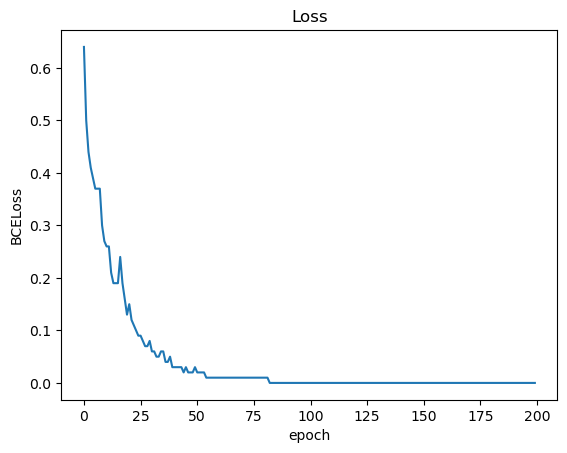

In [112]:
# 绘制loss曲线
import matplotlib.pyplot as plt
import numpy as np

y = np.array(loss_item)
plt.title("Loss")
plt.xlabel("epoch")
plt.ylabel("BCELoss")
plt.plot(y)
plt.show()

In [113]:
accuracy = accuracy_score(real, predict)
accuracy


0.9859100877192982

In [114]:
# model.eval()
predict = []
real = []
for idx, (input, target) in enumerate(get_dataloader(train=False)):
    input = input.to(device)
    target = target.to(device)
    with torch.no_grad():
        output = model(input)
        predicted_classes = (output > 0.5).float().view(-1)
        real = real + target.cpu().tolist()
        predict = predict + predicted_classes.cpu().tolist()
    
accuracy = accuracy_score(real, predict)
accuracy

0.7973856209150327

## LSTM

In [74]:
data = pd.read_csv('./data/processed_data2/2F5.csv')
data = data[data["label"] != 2]

vocabulary = Vocabulary.get_vocabulary_from_sequences(data.sequence.values)  #将蛋白质序列构造成词典


if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"


# df_opt = data.copy()
# create an test/training set only from the training set
# assign to training or test set
# df_opt["Set2"] = "eval"
# training_ = df_opt.sample(frac=0.75, random_state=1)
# df_opt.loc[training_.index, "Set2"] = "training"

# df_training = df_opt[df_opt["Set2"]=="training"]
# df_eval = df_opt[df_opt["Set2"]=="eval"]

In [75]:
X = data["gp120"]
Y = data["label"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1, train_size=0.75)

In [76]:
def transform(sequence, max_len):
    tensor = vocabulary.seq_to_tensor(sequence)
    if len(tensor)>max_len:
        tensor = tensor[: max_len]
        tensor[-1] = 22
        list = tensor.numpy().tolist()
    else:
        list = tensor.numpy().tolist()+[0]*(max_len-len(tensor))
    return list

class Dataset(Dataset):
    def __init__(self, train=True):
        train_data = list(X_train)
        eval_data = list(X_test)
        train_label = list(y_train)
        eval_label = list(y_test)
        self.data = train_data if train else eval_data
        self.label = train_label if train else eval_label
        
    def __getitem__(self, index):
        #获取内容
        sequence = self.data[index]
        sequence = transform(sequence, 500)
        #获取label
        label = self.label[index]
        return sequence, label
    
    def __len__(self):
        return len(self.data)
    

def collate_fn(batch):
    sequence, label = zip(*batch)
    content = [i for i in sequence]
    content = torch.LongTensor(content)
    label = torch.LongTensor(label)
    return content, label


def get_dataloader(train=True):
    dataset = Dataset(train)
    data_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    return data_loader


for index, (input, target) in enumerate(get_dataloader(train=False)):
    print(index)
    print(input.shape)
    print(input)
    print(target)
    break
    

0
torch.Size([32, 500])
tensor([[21,  6, 12,  ...,  0,  0,  0],
        [21,  6, 16,  ...,  0,  0,  0],
        [21,  3, 12,  ...,  0,  0,  0],
        ...,
        [21,  9, 16,  ...,  0,  0,  0],
        [21,  6,  9,  ...,  0,  0,  0],
        [21,  4, 12,  ...,  0,  0,  0]])
tensor([1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])


In [77]:
class MyModel_lstm_onedir(nn.Module):
    def __init__(self):
        super(MyModel_lstm_onedir, self).__init__()
        self.embedding = nn.Embedding(len(vocabulary), 24)    #每个残基用长度100的向量表示，这里没有用one-hot编码
        #加入LSTM
        self.lstm = nn.LSTM(input_size=24, hidden_size=100, num_layers=1, batch_first=True, bidirectional=False,dropout=0.2)
        self.fc = nn.Linear(100, 2)
    def forward(self, input):
        x = self.embedding(input)   #进行embedding操作,形状[batch_size, max_len,100]
        x, (h_n, c_n) = self.lstm(x)
        #x:[batch_size,max_len,hidden_size]  h_n:[2,batch_size,hiddem_size]
       
        output = h_n[-1,:,:] #正向最后一次的输出
        out = self.fc(output)
        return F.log_softmax(out, dim=1)

In [78]:
model = MyModel_lstm_onedir().to(device)
optimizer = Adam(model.parameters(), 0.01)
if os.path.exists("./model/pickles/base_model_2F5_2.pkl"):
    model.load_state_dict(torch.load("./model/pickles/base_model_2F5_2.pkl"))
    optimizer.load_state_dict(torch.load("./model/pickles/base_optimizer_2F5_2.pkl"))

/home/dldx/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [79]:
# 训练模型
loss_item = []
predict = []
real = []
for epoch in range(200):
    loss_list = []
    for idx, (input, target) in enumerate(get_dataloader(train=True)):
        input = input.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(input)
        loss = F.nll_loss(output, target)
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
    
        if idx%50 == 0:
            torch.save(model.state_dict(), "./model/pickles/base_model_2F5_2.pkl")
            torch.save(optimizer.state_dict(), "./model/pickles/base_optimizer_2F5_2.pkl")

        
    loss_item.append(round(mean(loss_list), 2)) 
    print("第{}个epoch, mean_loss:{}".format(epoch+1, round(mean(loss_list), 2)))
    



第1个epoch, mean_loss:0.55
第2个epoch, mean_loss:0.54
第3个epoch, mean_loss:0.54
第4个epoch, mean_loss:0.51
第5个epoch, mean_loss:0.53
第6个epoch, mean_loss:0.52
第7个epoch, mean_loss:0.51
第8个epoch, mean_loss:0.52
第9个epoch, mean_loss:0.51
第10个epoch, mean_loss:0.53
第11个epoch, mean_loss:0.54
第12个epoch, mean_loss:0.51
第13个epoch, mean_loss:0.51
第14个epoch, mean_loss:0.54
第15个epoch, mean_loss:0.51
第16个epoch, mean_loss:0.52
第17个epoch, mean_loss:0.52
第18个epoch, mean_loss:0.51
第19个epoch, mean_loss:0.51
第20个epoch, mean_loss:0.52
第21个epoch, mean_loss:0.52
第22个epoch, mean_loss:0.51
第23个epoch, mean_loss:0.53
第24个epoch, mean_loss:0.54
第25个epoch, mean_loss:0.52
第26个epoch, mean_loss:0.53
第27个epoch, mean_loss:0.53
第28个epoch, mean_loss:0.52
第29个epoch, mean_loss:0.53
第30个epoch, mean_loss:0.52
第31个epoch, mean_loss:0.51
第32个epoch, mean_loss:0.52
第33个epoch, mean_loss:0.52
第34个epoch, mean_loss:0.52
第35个epoch, mean_loss:0.51
第36个epoch, mean_loss:0.52
第37个epoch, mean_loss:0.51
第38个epoch, mean_loss:0.52
第39个epoch, mean_loss:

In [80]:
def eval():
    real = []
    predict = []
    loss_list=[]
    acc_list=[]
    for idx, (input, target) in enumerate(get_dataloader(train=False)):
        input = input.to(device)
        target = target.to(device)
        with torch.no_grad():
            output = model(input)
            
            cur_loss = F.nll_loss(output, target)      #log_softmax + nll_loss = 交叉熵损失
#             print(torch.exp(output[: ,1]))
#             print(target)
            loss_list.append(cur_loss.cpu().item())
            #计算准确率
            pred = output.max(dim=-1)[-1]
            real = real + target.cpu().tolist()
            predict = predict + pred.cpu().tolist()
    
    accuracy = accuracy_score(real, predict)
    print(accuracy)

    #         cur_acc = pred.eq(target).float().mean()
    #         acc_list.append(cur_acc.cpu().item())
        
    # print("total loss, acc",np.mean(loss_list), np.mean(acc_list))

In [81]:
eval()

0.738562091503268


## GRU

In [113]:
data = pd.read_csv('./data/processed_data2/2F5.csv')
data = data[data["label"] != 2]

vocabulary = Vocabulary.get_vocabulary_from_sequences(data.sequence.values)  #将蛋白质序列构造成词典


if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"


# df_opt = data.copy()
# create an test/training set only from the training set
# assign to training or test set
# df_opt["Set2"] = "eval"
# training_ = df_opt.sample(frac=0.75, random_state=1)
# df_opt.loc[training_.index, "Set2"] = "training"

# df_training = df_opt[df_opt["Set2"]=="training"]
# df_eval = df_opt[df_opt["Set2"]=="eval"]

In [114]:
X = data["gp120"]
Y = data["label"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1, train_size=0.75)

In [115]:
def transform(sequence, max_len):
    tensor = vocabulary.seq_to_tensor(sequence)
    if len(tensor)>max_len:
        tensor = tensor[: max_len]
        tensor[-1] = 22
        list = tensor.numpy().tolist()
    else:
        list = tensor.numpy().tolist()+[0]*(max_len-len(tensor))
    return list

class Dataset(Dataset):
    def __init__(self, train=True):
        train_data = list(X_train)
        eval_data = list(X_test)
        train_label = list(y_train)
        eval_label = list(y_test)
        self.data = train_data if train else eval_data
        self.label = train_label if train else eval_label
        
    def __getitem__(self, index):
        #获取内容
        sequence = self.data[index]
        sequence = transform(sequence, 500)
        #获取label
        label = self.label[index]
        return sequence, label
    
    def __len__(self):
        return len(self.data)
    

def collate_fn(batch):
    sequence, label = zip(*batch)
    content = [i for i in sequence]
    content = torch.LongTensor(content)
    label = torch.LongTensor(label)
    return content, label


def get_dataloader(train=True):
    dataset = Dataset(train)
    data_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    return data_loader


for index, (input, target) in enumerate(get_dataloader(train=False)):
    print(index)
    print(input.shape)
    print(input)
    print(target)
    break
    

0
torch.Size([32, 500])
tensor([[21,  6, 12,  ...,  0,  0,  0],
        [21,  3,  3,  ...,  0,  0,  0],
        [21, 12, 12,  ...,  0,  0,  0],
        ...,
        [21,  4,  9,  ...,  0,  0,  0],
        [21,  4,  3,  ...,  0,  0,  0],
        [21,  6, 12,  ...,  0,  0,  0]])
tensor([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 0, 1, 0, 1, 0, 0, 1])


In [116]:
class MyModel_gru_onedir(nn.Module):
    def __init__(self):
        super(MyModel_gru_onedir, self).__init__()
        self.embedding = nn.Embedding(len(vocabulary), 24)
        #加入GRU
        self.gru = nn.GRU(input_size=24, hidden_size=100, num_layers=2, batch_first=True, bidirectional=False, dropout=0.2)
        self.fc = nn.Linear(100, 2)
    def forward(self, input):
        x = self.embedding(input)
        x, h_n = self.gru(x)
        output = h_n[-1,:,:] #正向最后一次的输出
        
        out = self.fc(output)
        
        return F.log_softmax(out, dim = 1)

In [117]:
model = MyModel_gru_onedir().to(device)
optimizer = Adam(model.parameters(), 0.01)
if os.path.exists("./model/pickles/base_model_2F5_3.pkl"):
    model.load_state_dict(torch.load("./model/pickles/base_model_2F5_3.pkl"))
    optimizer.load_state_dict(torch.load("./model/pickles/base_optimizer_2F5_3.pkl"))

In [118]:
# 训练模型
loss_item = []
predict = []
real = []
for epoch in range(200):
    loss_list = []
    for idx, (input, target) in enumerate(get_dataloader(train=True)):
        input = input.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(input)
        loss = F.nll_loss(output, target)
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
    
        if idx%50 == 0:
            torch.save(model.state_dict(), "./model/pickles/base_model_2F5_3.pkl")
            torch.save(optimizer.state_dict(), "./model/pickles/base_optimizer_2F5_3.pkl")

        
    loss_item.append(round(mean(loss_list), 2)) 
    print("第{}个epoch, mean_loss:{}".format(epoch+1, round(mean(loss_list), 2)))
    



第1个epoch, mean_loss:0.56
第2个epoch, mean_loss:0.55
第3个epoch, mean_loss:0.53
第4个epoch, mean_loss:0.47
第5个epoch, mean_loss:0.51
第6个epoch, mean_loss:0.55
第7个epoch, mean_loss:0.39
第8个epoch, mean_loss:0.37
第9个epoch, mean_loss:0.37
第10个epoch, mean_loss:0.38
第11个epoch, mean_loss:0.37
第12个epoch, mean_loss:0.36
第13个epoch, mean_loss:0.35
第14个epoch, mean_loss:0.37
第15个epoch, mean_loss:0.38
第16个epoch, mean_loss:0.35
第17个epoch, mean_loss:0.37
第18个epoch, mean_loss:0.37
第19个epoch, mean_loss:0.34
第20个epoch, mean_loss:0.36
第21个epoch, mean_loss:0.38
第22个epoch, mean_loss:0.34
第23个epoch, mean_loss:0.37
第24个epoch, mean_loss:0.34
第25个epoch, mean_loss:0.36
第26个epoch, mean_loss:0.33
第27个epoch, mean_loss:0.35
第28个epoch, mean_loss:0.33
第29个epoch, mean_loss:0.36
第30个epoch, mean_loss:0.41
第31个epoch, mean_loss:0.34
第32个epoch, mean_loss:0.36
第33个epoch, mean_loss:0.35
第34个epoch, mean_loss:0.34
第35个epoch, mean_loss:0.35
第36个epoch, mean_loss:0.36
第37个epoch, mean_loss:0.35
第38个epoch, mean_loss:0.34
第39个epoch, mean_loss:

In [119]:
def eval():
    real = []
    predict = []
    loss_list=[]
    acc_list=[]
    for idx, (input, target) in enumerate(get_dataloader(train=False)):
        input = input.to(device)
        target = target.to(device)
        with torch.no_grad():
            output = model(input)
            
            cur_loss = F.nll_loss(output, target)      #log_softmax + nll_loss = 交叉熵损失
#             print(torch.exp(output[: ,1]))
#             print(target)
            loss_list.append(cur_loss.cpu().item())
            #计算准确率
            pred = output.max(dim=-1)[-1]
            real = real + target.cpu().tolist()
            predict = predict + pred.cpu().tolist()
    
    accuracy = accuracy_score(real, predict)
    print(accuracy)

    #         cur_acc = pred.eq(target).float().mean()
    #         acc_list.append(cur_acc.cpu().item())
        
    # print("total loss, acc",np.mean(loss_list), np.mean(acc_list))

In [120]:
eval()

0.7777777777777778


## Transformer

In [2]:
data = pd.read_csv('./data/processed_data2/2F5.csv')
data = data[data["label"] != 2]

vocabulary = Vocabulary.get_vocabulary_from_sequences(data.sequence.values)  #将蛋白质序列构造成词典


if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"



In [3]:
X = data["gp120"]
Y = data["label"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1, train_size=0.75)

In [5]:
def transform(sequence, max_len):
    tensor = vocabulary.seq_to_tensor(sequence)
    if len(tensor)>max_len:
        tensor = tensor[: max_len]
        tensor[-1] = 22
        list = tensor.numpy().tolist()
    else:
        list = tensor.numpy().tolist()+[0]*(max_len-len(tensor))
    return list

class Dataset(Dataset):
    def __init__(self, train=True):
        train_data = list(X_train)
        eval_data = list(X_test)
        train_label = list(y_train)
        eval_label = list(y_test)
        self.data = train_data if train else eval_data
        self.label = train_label if train else eval_label
        
    def __getitem__(self, index):
        #获取内容
        sequence = self.data[index]
        sequence = transform(sequence, 500)
        #获取label
        label = self.label[index]
        return sequence, label
    
    def __len__(self):
        return len(self.data)
    

def collate_fn(batch):
    sequence, label = zip(*batch)
    content = [i for i in sequence]
    content = torch.LongTensor(content)
    label = torch.LongTensor(label)
    return content, label


def get_dataloader(train=True):
    dataset = Dataset(train)
    data_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    return data_loader


for index, (input, target) in enumerate(get_dataloader(train=False)):
    print(index)
    print(input.shape)
    print(input)
    print(target.shape)
    break
    

0
torch.Size([32, 500])
tensor([[21,  6, 12,  ...,  0,  0,  0],
        [21,  6, 12,  ...,  0,  0,  0],
        [21, 12, 12,  ...,  0,  0,  0],
        ...,
        [21,  4, 12,  ...,  0,  0,  0],
        [21,  6, 12,  ...,  0,  0,  0],
        [21,  6, 12,  ...,  0,  0,  0]])
torch.Size([32])


In [6]:
# 定义Transformer模型
class TransformerModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, num_heads, dropout):
        super(TransformerModel, self).__init__()
        
        # Embedding层
        self.embedding = nn.Embedding(input_size, hidden_size)
        
        # Transformer编码器
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(hidden_size, num_heads, dim_feedforward=hidden_size, dropout=dropout),
            num_layers
        )
        
        # 输出层
        self.output_layer = nn.Linear(hidden_size, output_size)
        # self.activation = nn.ReLU()
    
    def forward(self, x):
        # Embedding
        x = self.embedding(x)
        
        # Transformer编码器
        x = self.encoder(x)
        
        # 平均池化
        x = torch.mean(x, dim=1)
        
        # 输出层
        x = self.output_layer(x)
        # x = self.activation(x)
        return x



In [7]:
# 设置超参数
input_size = len(vocabulary.vocabulary)  # 输入序列的词汇大小
output_size = 2  # 输出的数值大小
hidden_size = 64  # 隐藏层大小
num_layers = 3  # Transformer编码器的层数
num_heads = 4  # 注意力头的数量
dropout = 0.01  # Dropout率
batch_size = 32  # 批处理大小
num_epochs = 200  # 训练轮数
learning_rate = 0.001  # 学习率



# 创建模型和优化器
model = TransformerModel(input_size, output_size, hidden_size, num_layers, num_heads, dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
if os.path.exists("./model/pickles/base_model_2F5_4.pkl"):
    model.load_state_dict(torch.load("./model/pickles/base_model_2F5_4.pkl"))
    optimizer.load_state_dict(torch.load("./model/pickles/base_optimizer_2F5_4.pkl"))



In [8]:
# 训练模型
loss_item = []
predict = []
real = []
for epoch in range(200):
    loss_list = []
    for idx, (input, target) in enumerate(get_dataloader(train=True)):
        input = input.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(input)
        print(output.shape)
        print(target.shape)
        loss = criterion(output, target)
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
        break
        # Get the predicted classes
        predicted_classes = torch.argmax(output, dim=1)
        real = real + target.cpu().tolist()
        predict = predict + predicted_classes.cpu().tolist()
        
        if idx%50 == 0:
            torch.save(model.state_dict(), "./model/pickles/base_model_2F5_4.pkl")
            torch.save(optimizer.state_dict(), "./model/pickles/base_optimizer_2F5_4.pkl")
    break    
    loss_item.append(round(mean(loss_list), 2)) 
    print("第{}个epoch, mean_loss:{}".format(epoch+1, round(mean(loss_list), 2)))
    

# accuracy = accuracy_score(real, predict)
# print(accuracy)

torch.Size([32, 2])
torch.Size([32])


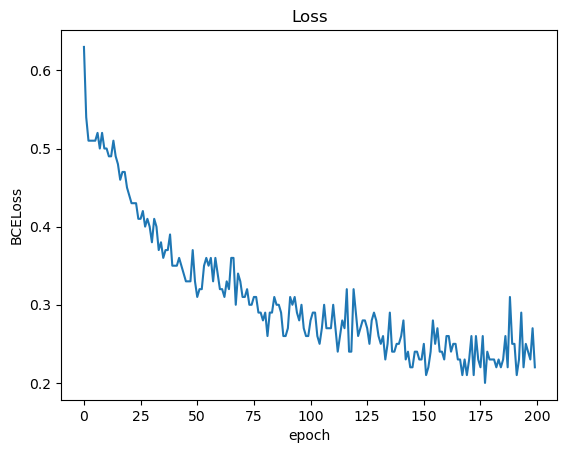

In [ ]:
# 绘制loss曲线
import matplotlib.pyplot as plt
import numpy as np

y = np.array(loss_item)
plt.title("Loss")
plt.xlabel("epoch")
plt.ylabel("BCELoss")
plt.plot(y)
plt.show()

In [ ]:
# model.eval()
predict = []
real = []
for idx, (input, target) in enumerate(get_dataloader(train=False)):
    input = input.to(device)
    target = target.to(device)
    with torch.no_grad():
        output = model(input)
        # Get the predicted classes
        predicted_classes = torch.argmax(output, dim=1)
        real = real + target.cpu().tolist()
        predict = predict + predicted_classes.cpu().tolist()
    
accuracy = accuracy_score(real, predict)
print(accuracy)

0.8888888888888888


## RNN

In [165]:
data = pd.read_csv('./data/processed_data2/2F5.csv')
data = data[data["label"] != 2]

vocabulary = Vocabulary.get_vocabulary_from_sequences(data.sequence.values)  #将蛋白质序列构造成词典


if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"


In [166]:
X = data["gp120"]
Y = data["label"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1, train_size=0.75)

In [167]:
def transform(sequence, max_len):
    tensor = vocabulary.seq_to_tensor(sequence)
    if len(tensor)>max_len:
        tensor = tensor[: max_len]
        tensor[-1] = 22
        list = tensor.numpy().tolist()
    else:
        list = tensor.numpy().tolist()+[0]*(max_len-len(tensor))
    return list

class Dataset(Dataset):
    def __init__(self, train=True):
        train_data = list(X_train)
        eval_data = list(X_test)
        train_label = list(y_train)
        eval_label = list(y_test)
        self.data = train_data if train else eval_data
        self.label = train_label if train else eval_label
        
    def __getitem__(self, index):
        #获取内容
        sequence = self.data[index]
        sequence = transform(sequence, 500)
        #获取label
        label = self.label[index]
        return sequence, label
    
    def __len__(self):
        return len(self.data)
    

def collate_fn(batch):
    sequence, label = zip(*batch)
    content = [i for i in sequence]
    content = torch.LongTensor(content)
    label = torch.LongTensor(label)
    return content, label


def get_dataloader(train=True):
    dataset = Dataset(train)
    data_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    return data_loader


for index, (input, target) in enumerate(get_dataloader(train=False)):
    print(index)
    print(input.shape)
    print(input)
    print(target)
    break
    

0
torch.Size([32, 500])
tensor([[21, 16,  6,  ...,  0,  0,  0],
        [21,  4,  9,  ...,  0,  0,  0],
        [21,  6, 12,  ...,  0,  0,  0],
        ...,
        [21,  6, 12,  ...,  0,  0,  0],
        [21,  6, 12,  ...,  0,  0,  0],
        [21,  6, 16,  ...,  0,  0,  0]])
tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1])


In [168]:
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(len(vocabulary), input_size)
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True, num_layers=1, dropout=0.1)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = x[:, -1, :]  # Take the output of the last time step
        
        x = self.fc(x)
        # x = self.relu(x)
        return x


In [169]:
input_size = 50  # Size of the input data (binary sequences)
hidden_size = 100  # Number of hidden units
num_classes = 2  # Number of output classes

# Instantiate the model
model = RNNClassifier(input_size, hidden_size, num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

if os.path.exists("./model/pickles/base_model_2F5_5.pkl"):
    model.load_state_dict(torch.load("./model/pickles/base_model_2F5_5.pkl"))
    optimizer.load_state_dict(torch.load("./model/pickles/base_optimizer_2F5_5.pkl"))

/home/dldx/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [170]:
# 训练模型
loss_item = []
predict = []
real = []
for epoch in range(150):
    loss_list = []
    for idx, (input, target) in enumerate(get_dataloader(train=True)):
        input = input.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(input)
        loss = criterion(output, target)
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()

        # Get the predicted classes
        predicted_classes = torch.argmax(output, dim=1)
        real = real + target.cpu().tolist()
        predict = predict + predicted_classes.cpu().tolist()

        if idx%50 == 0:
            torch.save(model.state_dict(), "./model/pickles/base_model_2F5_5.pkl")
            torch.save(optimizer.state_dict(), "./model/pickles/base_optimizer_2F5_5.pkl")

        
    loss_item.append(round(mean(loss_list), 2)) 
    print("第{}个epoch, mean_loss:{}".format(epoch+1, round(mean(loss_list), 2)))
    
accuracy = accuracy_score(real, predict)
print(accuracy)


第1个epoch, mean_loss:0.55
第2个epoch, mean_loss:0.53
第3个epoch, mean_loss:0.53
第4个epoch, mean_loss:0.51
第5个epoch, mean_loss:0.52
第6个epoch, mean_loss:0.53
第7个epoch, mean_loss:0.53
第8个epoch, mean_loss:0.51
第9个epoch, mean_loss:0.52
第10个epoch, mean_loss:0.52
第11个epoch, mean_loss:0.51
第12个epoch, mean_loss:0.53
第13个epoch, mean_loss:0.52
第14个epoch, mean_loss:0.54
第15个epoch, mean_loss:0.53
第16个epoch, mean_loss:0.52
第17个epoch, mean_loss:0.53
第18个epoch, mean_loss:0.55
第19个epoch, mean_loss:0.52
第20个epoch, mean_loss:0.52
第21个epoch, mean_loss:0.52
第22个epoch, mean_loss:0.52
第23个epoch, mean_loss:0.52
第24个epoch, mean_loss:0.51
第25个epoch, mean_loss:0.55
第26个epoch, mean_loss:0.52
第27个epoch, mean_loss:0.51
第28个epoch, mean_loss:0.51
第29个epoch, mean_loss:0.52
第30个epoch, mean_loss:0.53
第31个epoch, mean_loss:0.51
第32个epoch, mean_loss:0.53
第33个epoch, mean_loss:0.53
第34个epoch, mean_loss:0.53
第35个epoch, mean_loss:0.51
第36个epoch, mean_loss:0.52
第37个epoch, mean_loss:0.51
第38个epoch, mean_loss:0.52
第39个epoch, mean_loss:

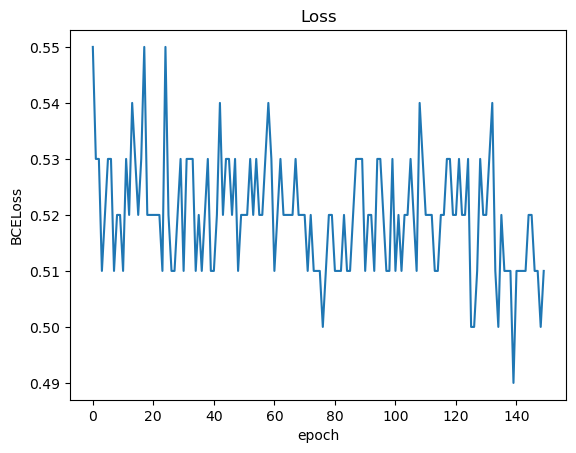

In [171]:
# 绘制loss曲线
import matplotlib.pyplot as plt
import numpy as np

y = np.array(loss_item)
plt.title("Loss")
plt.xlabel("epoch")
plt.ylabel("BCELoss")
plt.plot(y)
plt.show()

In [173]:
# model.eval()
predict = []
real = []
for idx, (input, target) in enumerate(get_dataloader(train=False)):
    input = input.to(device)
    target = target.to(device)
    with torch.no_grad():
        output = model(input)
        # Get the predicted classes
        predicted_classes = torch.argmax(output, dim=1)
        real = real + target.cpu().tolist()
        predict = predict + predicted_classes.cpu().tolist()
    
accuracy = classification_report(real, predict)
print(accuracy)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.74      1.00      0.85       113

    accuracy                           0.74       153
   macro avg       0.37      0.50      0.42       153
weighted avg       0.55      0.74      0.63       153



/home/dldx/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dldx/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dldx/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)